# Implementation of EfficientNetB5 for the APTOS 2019 competition with Keras

Mainly inspired from Carlo Lepelaars' kernel: https://www.kaggle.com/carlolepelaars/efficientnetb5-with-keras-aptos-2019

In [1]:
EFFNET = 5

In this kernel we will implement EfficientNet for medical images ([APTOS 2019](https://www.kaggle.com/c/aptos2019-blindness-detection) competition). EfficientNet was released this June (2019) by Google AI and is the new state-of-the-art on ImageNet. It introduces a systematic way to scale CNN (Convolutional Neural Networks) in a nearly optimal way. For this kernel we will use the B5 version, but feel free to play with the larger models. This kernel provides weights for EfficientNetB0 through B5. Weights for EfficientNetB6 and B7 can be found in [Google AI's repository for EfficientNet](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet). I highly recommend you to read [the EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf) as it signifies a fundamental shift in how the Deep Learning community will approach model scaling!

Also, check out this [video on EfficientNet by Henry AI Labs](https://youtu.be/3svIm5UC94I) for a clear explanation!

If you like this Kaggle kernel, feel free to give an upvote and leave a comment!

Image: an overview of model architectures and their performance on [ImageNet](http://www.image-net.org/). We can see that EfficientNet achieves state-of-the-art and uses a lot less parameters than most modern CNN architectures.

[Source: EfficientNet Paper](https://arxiv.org/pdf/1905.11946.pdf)

![](https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png)

## Table Of Contents

- [Dependencies](#1)
- [Preparation](#2)
- [Metric (Quadratic Weighted Kappa)](#3)
- [EDA (Exploratory Data Analysis)](#4)
- [Preprocessing](#5)
- [Modeling (EfficientNetB5)](#6)
- [Evaluation](#7)
- [Submission](#8)

## Dependencies <a id="1"></a>

In [2]:
import os
import sys

# Standard dependencies
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

# Path specifications
KAGGLE_DIR = '../input/aptos2019-blindness-detection/'
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TEST_DF_PATH = KAGGLE_DIR + 'test.csv'
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"
TEST_IMG_PATH = KAGGLE_DIR + 'test_images/'

# Specify title of our final model
SAVED_MODEL_NAME = 'effnet_b{}_model.h5'.format(EFFNET)

# Set seed for reproducability
seed = 1234
rn.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# For keeping time. GPU limit for this competition is set to ± 9 hours.
t_start = time.time()

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Special thanks to [qubvel](https://github.com/qubvel/efficientnet) for sharing an amazing wrapper to get the EfficientNet architecture in one line of code!

Thanks to the amazing wrapper by [qubvel](https://github.com/qubvel/efficientnet) we can load in a model like the Keras API. We specify the input shape and that we want the model without the top (the final Dense layer). Then we load in the weights which are provided in [this Kaggle dataset](https://www.kaggle.com/ratthachat/efficientnet-keras-weights-b0b5). Note that we will use the [RAdam optimizer](https://arxiv.org/pdf/1908.03265v1.pdf) since it often yields better convergence than Vanilla Adam. Thanks to CyberZHG who implemented [RAdam for Keras](https://github.com/CyberZHG/keras-radam/blob/master/keras_radam/optimizers.py).

In [3]:
!pip install ../input/efficientnet100
!pip install ../input/kerasradam/
!pip install ../input/kerascontrib/
!pip install ../input/ipythonautotime/
%load_ext autotime

Processing /kaggle/input/efficientnet100
  Created wheel for efficientnet: filename=efficientnet-1.0.0-cp36-none-any.whl size=17684 sha256=b0604f23f9775b62379bd49b3d6cd7da152dd104a2518df92bdafdfbbdae82e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-wz7w14c3/wheels/e3/1d/34/c0d8f68611afd4d7e5b2aed7edfb63de5e225017a8cf1f355d
Successfully built efficientnet
Processing /kaggle/input/kerasradam
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=15620 sha256=71090d95010b72574d03f2757e2008c950be1ed9345d6bae6cbfc1773e2ff5ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-dllrk9pm/wheels/d1/26/1c/672b21c1bf006516dc644928a0d83a365d442fdda2d5ec1b0e
Successfully built keras-rectified-adam
Processing /kaggle/input/kerascontrib
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=a29425cde86f43dcc0085c161dbefe4acfe27364b64e15ead2b54cb465b18394
  Stored in directory: /tmp/pip-ephem-wheel-cache-ll

In [4]:
exec('from efficientnet.keras import EfficientNetB{} as EfficientNet'.format(EFFNET))

from keras_radam import RAdam
from keras_contrib.layers import GroupNormalization

from sklearn.metrics import accuracy_score

time: 2.19 s


## Preparation <a id="2"></a>

By examining the data we can readily see that we do not have that much data (± 700 samples per class). It is probably a good idea to use data augmentation to increase robustness of our model (See the modeling section).

We could also try to use additional data from previous competitions to increase performance. Although I do not implement this in the kernel, feel free to experiment with adding data. Additional data can be found in [this Kaggle dataset](https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images) (± 35000 additional images).

In [5]:
TRAIN_TEST_RATIO = 1 - (70 + 15) / (70 + 15 + 15)
TRAIN_VAL_RATIO = 1 - 70 / (70 + 15)

time: 726 µs


In [6]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH).sample(frac=1, random_state=seed)
# Add extension to id_code
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
# display(train_df.head())

print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)  # .sample(frac=1, random_state=seed)
# Add extension to id_code
test_df['id_code'] = test_df['id_code'] + ".png"
test_df = test_df.rename(columns={'diagnosis': 'label'})
print(f"Testing Images: {test_df.shape[0]}")
# display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662
Image IDs (TEST)
Testing Images: 1928
time: 49.4 ms


The original image size from the [EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf) for EfficientNetB5 is 456x456x3. We are however not bound by this and can use a smaller size if we want. The original image sizes used for every version of EfficientNet are:

- EfficientNetB0 - (224, 224, 3)
- EfficientNetB1 - (240, 240, 3)
- EfficientNetB2 - (260, 260, 3)
- EfficientNetB3 - (300, 300, 3)
- EfficientNetB4 - (380, 380, 3)
- **EfficientNetB5 - (456, 456, 3)**
- EfficientNetB6 - (528, 528, 3)
- EfficientNetB7 - (600, 600, 3)


In [7]:
# Specify image size
effnet_to_img_size = dict(enumerate(
    [(224, 224), (240, 240), (260, 260), (300, 300), (380, 380), (456, 456), (528, 528), (600, 600)]
))
IMG_WIDTH, IMG_HEIGHT = effnet_to_img_size[EFFNET]
CHANNELS = 3

# Specify number of epochs
effnet_to_nb_epochs = dict(enumerate(
    [30, 30, 30, 30, 30, 25, 20, 15]
    # [30, 22, 17, 9, 8, 8]
))
EPOCHS = effnet_to_nb_epochs[EFFNET]

time: 1.65 ms


## Metric (Quadratic Weighted Kappa) <a id="3"></a>

The metric that is used for this competition is Quadratic Weighted Kappa (QWK) ([Kaggle's Explanation](https://www.kaggle.com/c/aptos2019-blindness-detection/overview/evaluation)) 

The formula for weighted kappa is:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2a496e1cef7d812b83bdbb725d291748cf0183f5)

In this case we are going to optimize Mean Squared Error (MSE) (See Modeling section) since we are using regression and by optimizing MSE we are also optimizing QWK as long as we round predictions afterwards. Additionally we are going to same the model which achieves the best QWK score on the validation data through a custom Keras Callback.

For a more detailed and practical explanation of QWK I highly recommend [this Kaggle kernel](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps).

In [8]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    
    :param model: A Keras model object
    :param generator: A Keras ImageDataGenerator object
    
    :return: A tuple with two Numpy Arrays. One containing the predictions
    and one containing the labels
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel().astype(int)

time: 2.04 ms


In [9]:
class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        
        :param epoch: The current epoch number
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

time: 2.66 ms


## EDA (Exploratory Data Analysis) <a id="4"></a>

For EDA on image datasets I think one should at least examine the label distribution, the images before preprocessing and the images after preprocessing. Through examining these three aspects we can get a good sense of the problem. Note that the distribution on the test set can still vary wildly from the training data.

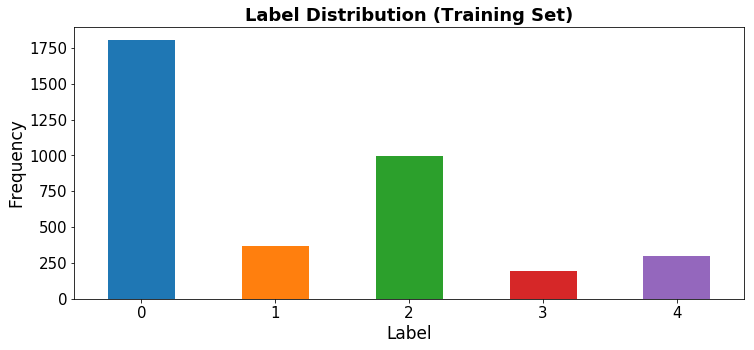

time: 323 ms


In [10]:
# Label distribution
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

We will visualize a random image from every label to get a general sense of the distinctive features that seperate the classes. We will take this into account and try to enhance these features in our preprocessing. For these images there some to be increasingly more spots and stains on the retina as diabetic retinopathy worsens.

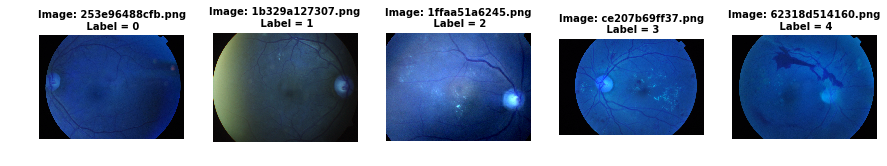

time: 1.64 s


In [11]:
# Example from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"{TRAIN_IMG_PATH}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## Preprocessing <a id="5"></a>

Here we will use the auto-cropping method with Ben's preprocessing as explained in [this kernel](https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping).

In [12]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    # image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

time: 4.07 ms


After preprocessing we have managed to enhance the distinctive features in the images. This will increase performance when we train our EfficientNet model.

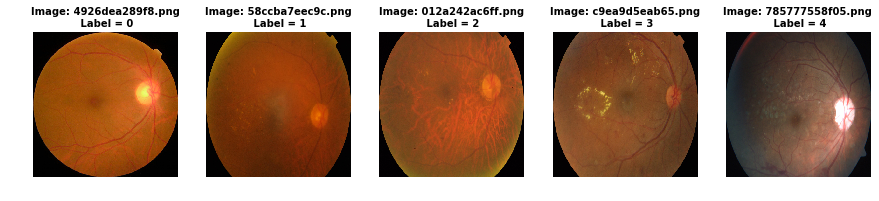

time: 1.69 s


In [13]:
# Example of preprocessed images from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f"{TRAIN_IMG_PATH}{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [14]:
# Labels for training data
y_labels = train_df['diagnosis'].values

time: 600 µs


## Modeling (EfficientNetB5) <a id="6"></a>

Since we want to optimize the Quadratic Weighted Kappa score we can formulate this challenge as a regression problem. In this way we are more flexible in our optimization and we can yield higher scores than solely optimizing for accuracy. We will optimize a pre-trained EfficientNetB5 with a few added layers. The metric that we try to optimize is the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error). This is the mean of squared differences between our predictions and labels, as showed in the formula below. By optimizing this metric we are also optimizing for Quadratic Weighted Kappa if we round the predictions afterwards.

![](https://study.com/cimages/multimages/16/4e7cf150-0179-4d89-86f2-5cbb1f51c266_meansquarederrorformula.png)

Since we are not provided with that much data (3662 images), we will augment the data to make the model more robust. We will rotate the data on any angle. Also, we will flip the data both horizontally and vertically. Lastly, we will divide the data by 128 for normalization.

In [15]:
# We use a small batch size so we can handle large images easily
BATCH_SIZE = 4

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=TRAIN_VAL_RATIO,
                                   preprocessing_function=preprocess_image, 
                                   rescale=1 / 255.)

# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other', 
                                                    subset='training',
                                                    seed=seed)

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis',
                                                  directory = TRAIN_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other',
                                                  subset='validation',
                                                  seed=seed)

Found 3016 validated image filenames.
Found 646 validated image filenames.
time: 1.18 s


In [16]:
# Load in EfficientNetB5
effnet = EfficientNet(weights=None,  # None,  # 'imagenet',
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
effnet.load_weights(
    '../input/efficientnet-weights-for-keras/advprop/notop/efficientnet-b{}_weights_imagenet_1000_advprop_notop.h5'.format(
        EFFNET
    )
)

time: 29.1 s


Batch Normalization becomes unstable with small batch sizes (<16) and that is why we use [Group Normalization ](https://arxiv.org/pdf/1803.08494.pdf) layers instead. Big thanks to [Somshubra Majumdar](https://github.com/titu1994) for building an implementation of Group Normalization for Keras.

Keras makes it incredibly easy to replace layers. Just loop through the layers and replace each Batch Normalization layer with a Group Normalization layer.

In [17]:
# Replace all Batch Normalization layers by Group Normalization layers
for i, layer in enumerate(effnet.layers):
    if "batch_normalization" in layer.name:
        effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

time: 1.57 ms


In [18]:
def build_model():
    """
    A custom implementation of EfficientNetB5
    for the APTOS 2019 competition
    (Regression)
    """
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse',
                  optimizer=RAdam(learning_rate=0.00005), 
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

# Initialize model
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 28,523,771
Trainable params: 28,351,035
Non-trainable params: 172,736
_________________________________________________________________
None
time: 11.6 s


We train all layers in the network. This is the traditional transfer learning approach were we can optimize and model for almost any image content. Since the pre-trained model was trained on [ImageNet](http://www.image-net.org/) and not on medical images, there are some limitations to this approach for out challenge.

After each epoch we save the model if it is better than the previous one, according to the Quadratic Weighted Kappa score on the validation set. We also stop training if the MSE on the validation set doesn't go down for 4 epochs. This way we can counter overfitting.

Another option we could use is to directly use Quadratic Weighted Kappa as a loss function. Feel free to experiment with this. An implementation of a [QWK loss function for Tensorflow/Keras can be found in this Kaggle kernel](https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow).

In [19]:
# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()
# Monitor MSE to avoid overfitting and save best model
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=EPOCHS // 2)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=EPOCHS // 4, 
                        verbose=1, 
                        mode='auto', 
                        epsilon=0.0001)

# Begin training
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, es, rlr])

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/25
754/754 [==============================] - 804s 1s/step - loss: 1.4223 - mean_squared_error: 1.4223 - acc: 0.4738 - val_loss: 0.6703 - val_mean_squared_error: 0.6703 - val_acc: 0.6848
val_kappa: 0.6527
Validation Kappa has improved. Saving model.
Epoch 2/25
754/754 [==============================] - 718s 953ms/step - loss: 0.7345 - mean_squared_error: 0.7345 - acc: 0.5288 - val_loss: 0.4329 - val_mean_squared_error: 0.4329 - val_acc: 0.7523
val_kappa: 0.8322
Validation Kappa has improved. Saving model.
Epoch 3/25
754/754 [==============================] - 714s 947ms/step - loss: 0.6298 - mean_squared_error: 0.6298 - acc: 0.5746 - val_loss: 0.4495 - val_mean_squared_error: 0.4495 - val_acc: 0.7345
val_kappa: 0.8012
Epoch 4/25
754/754 [==============================] - 711s 943ms/step - loss: 0.5156 - mean_squared_error: 0.5156 - acc: 0.6353 - val_loss: 0.4667 - val_mean_squared_error: 0.4667 - val_acc: 0.6807
val_kappa: 0.7997
Epoch 5/25
754/754 [=============================

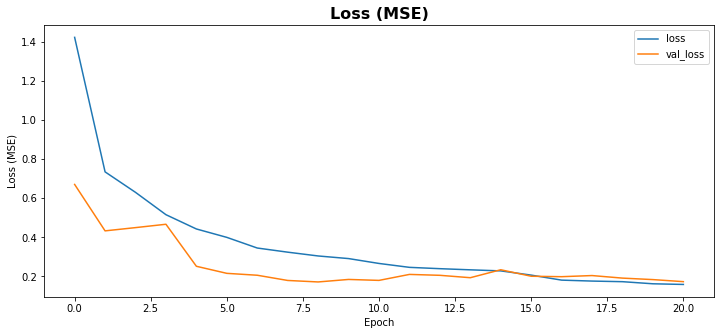

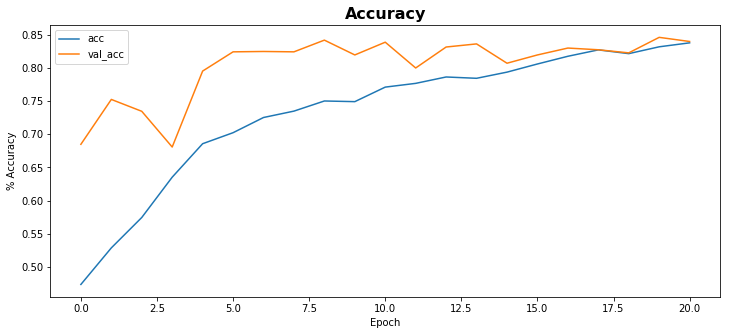

time: 785 ms


In [20]:
# Visualize mse
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

## Evaluation <a id="7"></a>

In [21]:
# Load best weights according to MSE
model.load_weights(SAVED_MODEL_NAME)

time: 5.13 s


To evaluate our performance we predict values from the generator and round them of to the nearest integer to get valid predictions. After that we calculate the Quadratic Weighted Kappa score on the training set and the validation set.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

time: 137 ms


We can optimize the validation score by doing a [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) over rounding thresholds instead of doing "normal" rounding. The "OptimizedRounder" class by [Abhishek Thakur](https://www.kaggle.com/abhishek) is a great way to do this. The original class can be found in [this Kaggle kernel](https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa).

In [23]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p.astype(int)

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

time: 7.91 ms


In [24]:
# Optimize on validation data and evaluate again
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
optR = OptimizedRounder()
optR.fit(y_val_preds, val_labels)
coefficients = optR.coefficients()
opt_val_predictions = optR.predict(y_val_preds, coefficients)
new_val_score = cohen_kappa_score(val_labels, opt_val_predictions, weights="quadratic")
new_acc_val_score = accuracy_score(val_labels, opt_val_predictions)

time: 1min 56s


In [25]:
print(f"Optimized Thresholds:\n{coefficients}\n")

print(f"The Validation Quadratic Weighted Kappa (QWK)\n\
with optimized rounding thresholds is: {round(new_val_score, 5)}\n")

print(f"The Validation Accuracy\n\
with optimized rounding thresholds is: {round(new_acc_val_score, 5)}\n")

Optimized Thresholds:
[0.54 1.54 2.59 3.14]

The Validation Quadratic Weighted Kappa (QWK)
with optimized rounding thresholds is: 0.93712

The Validation Accuracy
with optimized rounding thresholds is: 0.86533

time: 2.94 ms


Confusion matrix, without normalization
[[323   2   0   0   0]
 [  2  36  13   4   0]
 [  1  17 160  13   0]
 [  0   0  14  11   8]
 [  0   0   8   5  29]]


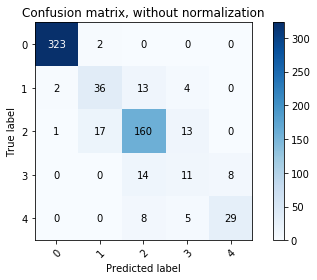

time: 376 ms


In [26]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(val_labels, opt_val_predictions, classes=np.array(['0', '1', '2', '3', '4']),
                      title='Confusion matrix, without normalization')
plt.show()

## Submission <a id="8"></a>

Since the test set is not that large we will not be using a generator for making the final predictions on the test set.

In [27]:
# Place holder for diagnosis column
test_df['diagnosis'] = np.zeros(test_df.shape[0]) 
# For preprocessing test images
test_generator = ImageDataGenerator(preprocessing_function=preprocess_image, 
                                    rescale=1 / 255.).flow_from_dataframe(test_df, 
                                                                          x_col='id_code', 
                                                                          y_col='diagnosis',
                                                                          directory=TEST_IMG_PATH,
                                                                          target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                          batch_size=BATCH_SIZE,
                                                                          class_mode='other',
                                                                          shuffle=False,
                                                                          seed=seed)

Found 1928 validated image filenames.
time: 572 ms


As mentioned earlier, we use custom thresholds to optimize our score. The same thresholds should be used when creating the final predictions.

In [28]:
# Make final predictions, round predictions and save to csv
y_test, _ = get_preds_and_labels(model, test_generator)
y_test = optR.predict(y_test, coefficients).astype(np.uint8)
test_df['diagnosis'] = y_test
# Remove .png from ids
test_df['id_code'] = test_df['id_code'].str.replace(r'.png$', '')
test_df.to_csv('submission.csv', index=False)

time: 2min 28s


After creating the submission I always check the format and the distribution of the test predictions. Do they makes sense given the label distribution of the training data?

In [29]:
# Check submission
print("Submission File")
display(test_df.head())

Submission File


,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,3


time: 12.4 ms


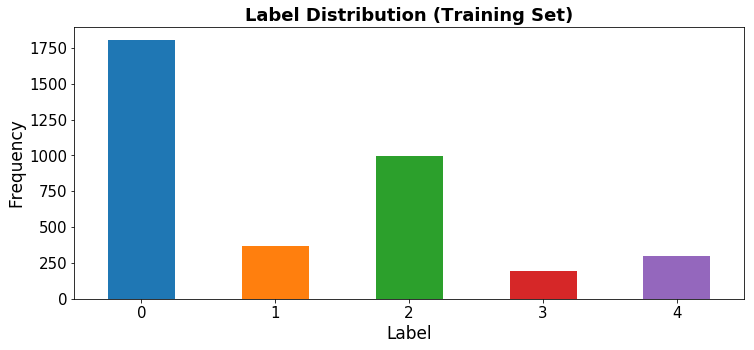

time: 275 ms


In [30]:
# Label distribution
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

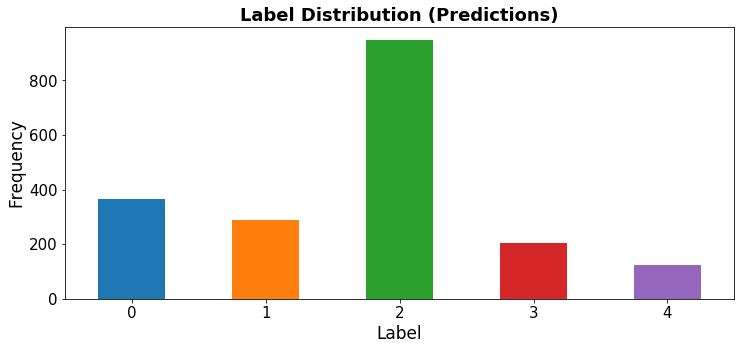

time: 263 ms


In [31]:
# Distribution of predictions
test_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                      figsize=(12,5), 
                                                      rot=0)
plt.title("Label Distribution (Predictions)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

In [32]:
# Check kernels run-time. GPU limit for this competition is set to ± 9 hours.
t_finish = time.time()
total_time = round((t_finish-t_start) / 3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, 
                                                      int(total_time*60)))

Kernel runtime = 5.0096 hours (300 minutes)
time: 3.01 ms


That's it! Feel free to experiment with this kernel and try a larger implementation of EfficientNet. This kernel provides weights for EfficientNetB0 through B5. Weights for EfficientNetB6 and B7 can be found in [Google AI's repository for EfficientNet](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet).

**If you like this Kaggle kernel, feel free to give an upvote and leave a comment! I will try to implement your suggestions in this kernel!**